In [1]:
import os
import splitfolders
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101V2

In [3]:
# Path ke folder dataset asli
original_dataset_dir = './data/cat_dataset'

# Membagi dataset menjadi train dan validation dengan rasio 90% train dan 10% validation
splitfolders.ratio(original_dataset_dir, output="./data/cat_dataset_splitted", seed=42, ratio=(.9, .1))

Copying files: 3762 files [00:00, 4635.97 files/s]


In [4]:
# Definisikan direktori train dan validation setelah splitting
base_dir = './data/cat_dataset_splitted'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

In [6]:
os.listdir(train_dir)

['Abyssinian',
 'Bengal',
 'Bombay',
 'British Shorthair',
 'Domestic',
 'Maine Coon',
 'Persian',
 'Ragdoll',
 'Siamese',
 'Sphynx']

In [7]:
os.listdir(validation_dir)

['Abyssinian',
 'Bengal',
 'Bombay',
 'British Shorthair',
 'Domestic',
 'Maine Coon',
 'Persian',
 'Ragdoll',
 'Siamese',
 'Sphynx']

In [8]:
# Preprocessing dan augmentasi untuk dataset train dan validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
# Menyiapkan generator data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 3381 images belonging to 10 classes.
Found 753 images belonging to 10 classes.


In [13]:
# Membuat base model ResNet101V2 dengan imagenet weights
base_model = ResNet101V2(include_top=False, weights='imagenet', pooling='avg')
base_model.trainable = False  # Membekukan lapisan dari base model

In [14]:
# Membangun model menggunakan Sequential
model = Sequential([
    base_model,            # Menambahkan base model sebagai feature extractor
    Flatten(),
    Dropout(0.25),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(train_generator.num_classes, activation='softmax')  # Output layer sesuai jumlah kelas
])

In [15]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Menyiapkan Early Stopping untuk mencegah overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta= 0.01 ,patience=5, restore_best_weights=True)

In [16]:
# Training model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

d:\python-app-web\praktikum\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5606 - loss: 1.4217

d:\python-app-web\praktikum\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.5619 - loss: 1.4172 - val_accuracy: 0.8367 - val_loss: 0.5014
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.8156 - loss: 0.5700 - val_accuracy: 0.8499 - val_loss: 0.4526
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.8096 - loss: 0.5437 - val_accuracy: 0.8287 - val_loss: 0.4876
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.8561 - loss: 0.4306 - val_accuracy: 0.8606 - val_loss: 0.4172
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.8646 - loss: 0.4151 - val_accuracy: 0.8725 - val_loss: 0.3869
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.8583 - loss: 0.3880 - val_accuracy: 0.8805 - val_loss: 0.3762
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.8839 - loss: 0.3537 - val_accuracy: 0.8792 - val_loss: 0.3844
Epoch 8/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.8732 - loss: 0.3598 - val_accuracy: 0.880

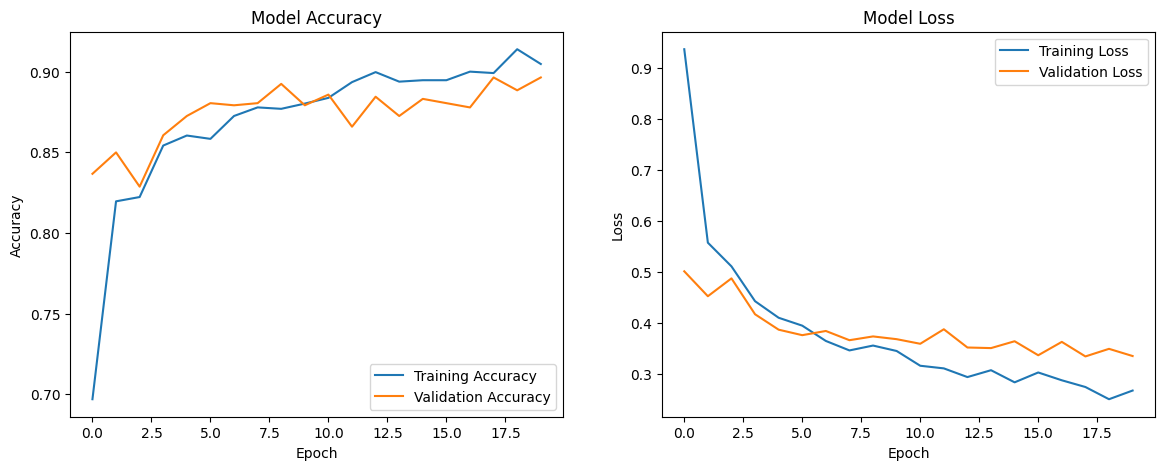

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()


In [18]:
# Menyimpan model ke dalam file dengan format HDF5
model.save("model/cat_model.h5")


In [25]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.preprocessing import image
# from tkinter import Tk
# from tkinter.filedialog import askopenfilename

# # Memuat model yang sudah disimpan
# model = tf.keras.models.load_model("model/cat_model.h5")

# # Label kelas sesuai urutan yang digunakan saat training
# class_labels = ["Abyssinian", "Bengal", "Bombay", "British Shorthair", 
#                 "Domestic", "Maine Coon", "Persian", "Ragdoll", 
#                 "Siamese", "Sphynx"]

# # Membuka dialog untuk memilih gambar
# Tk().withdraw()  # Menyembunyikan jendela utama Tkinter
# filename = askopenfilename(title="Pilih Gambar", filetypes=[("Image files", "*.jpg;*.jpeg;*.png")])

# if filename:
#     # Prediksi menggunakan gambar yang dipilih
#     img = image.load_img(filename, target_size=(224, 224))  # Resize gambar sesuai ukuran input model
#     img_array = image.img_to_array(img)  # Konversi ke array
#     img_array = np.expand_dims(img_array, axis=0)  # Menambahkan dimensi batch
#     img_array /= 255.  # Rescale

#     # Prediksi
#     pred = model.predict(img_array)
#     pred_class = np.argmax(pred, axis=1)
    
#     # Tampilkan hasil prediksi
#     print(f'Prediksi: {class_labels[pred_class[0]]}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediksi: Domestic
